# Importing Libraries

In [2]:
import warnings 
warnings.filterwarnings("ignore", category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib.colors import LinearSegmentedColormap
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4" 
from joblib import Parallel, delayed

## Loading Data

In [3]:
df= pd.read_csv('SPAM text message 20170820 - Data.csv')

## Exploring Data

In [7]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.shape

(5572, 2)

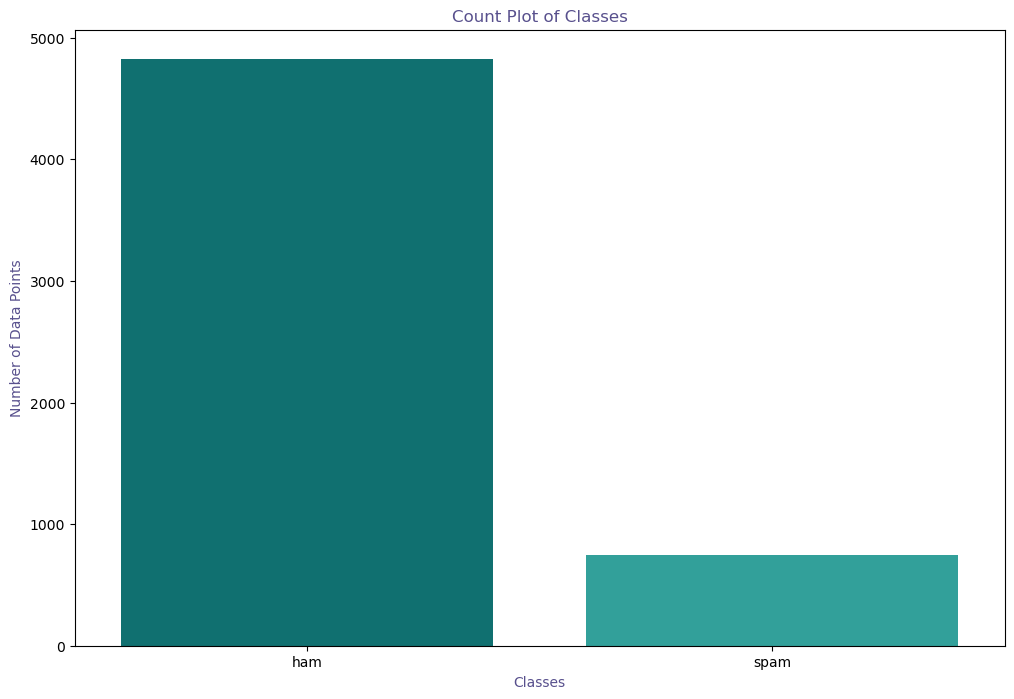

In [10]:
palette = ["#008080", "#20B2AA"]  # Teal and light teal

plt.figure(figsize=(12, 8))
fg = sns.countplot(x=df["Category"], palette=palette)

fg.set_title("Count Plot of Classes", color="#58508d")
fg.set_xlabel("Classes", color="#58508d")
fg.set_ylabel("Number of Data Points", color="#58508d")

plt.show()

## Feature engineering

In [4]:
df["No_of_Characters"] = df["Message"].apply(len)
df["No_of_Words"]=df.apply(lambda row: nltk.word_tokenize(row["Message"]), axis=1).apply(len)
df["No_of_sentence"]=df.apply(lambda row: nltk.sent_tokenize(row["Message"]), axis=1).apply(len)

df.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,5572.0,80.368988,59.926946,2.0,35.75,61.0,122.0,910.0
No_of_Words,5572.0,18.826992,13.853616,1.0,9.00,15.0,27.0,220.0
No_of_sentence,5572.0,2.004666,1.539516,1.0,1.00,2.0,2.0,38.0


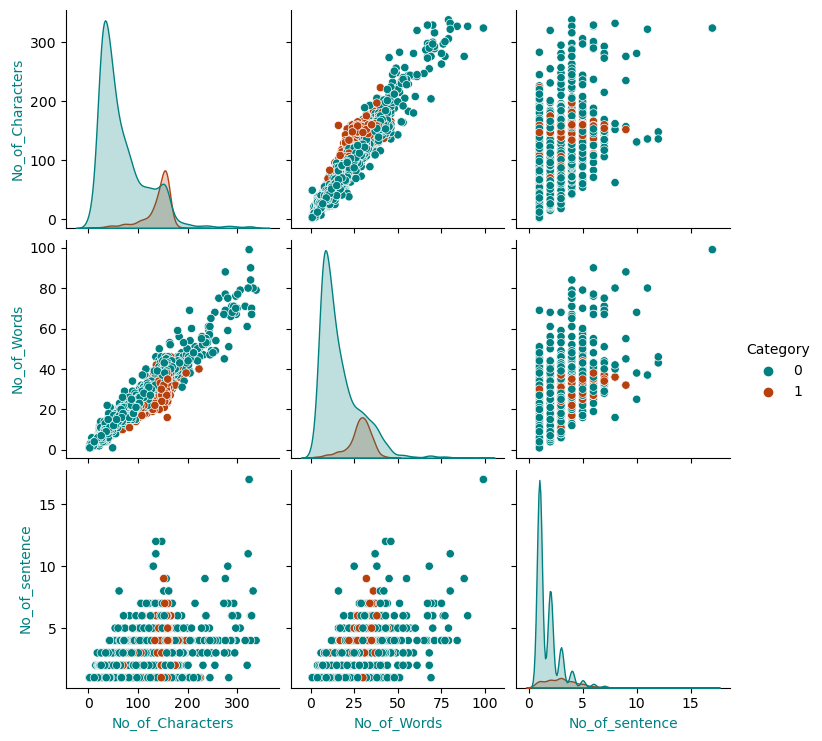

In [52]:
cols= ["#008080", "#b7410e"] 
pair_plot = sns.pairplot(data=df, hue="Category", palette= cols)

for ax in pair_plot.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), color="#008080")
    ax.set_ylabel(ax.get_ylabel(), color="#008080")
    ax.title.set_color("#008080")

plt.show()

## Detecting Outliers

In [11]:
df = df[(df["No_of_Characters"]<350)]
df.shape

(5547, 5)

<Figure size 1200x800 with 0 Axes>

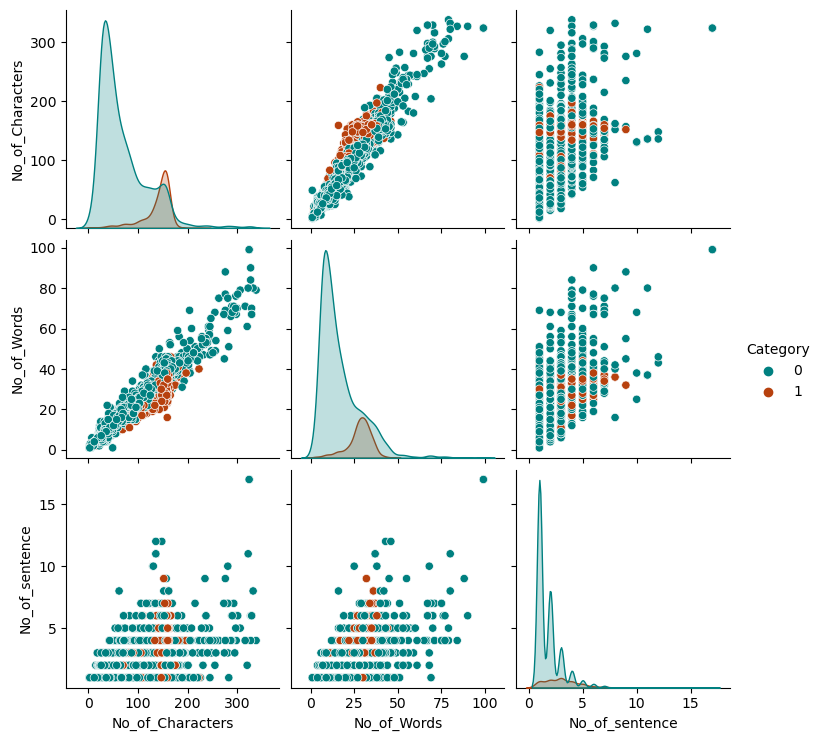

In [53]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=df, hue="Category",palette=cols)
plt.show(fg)

## Data Preprocessing

In [5]:
def Clean(Message):
    sms = re.sub('[^a-zA-Z]', ' ', Message) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowercase
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

df["Clean_Message"] = df["Message"].apply(Clean)
print("\033[1m\u001b[96m The First 5 Messages after cleaning:\033[0m", *df["Clean_Message"][:5], sep="\n")


 The First 5 Messages after cleaning:
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


## Tokenization

In [6]:
df["Tokenize_Message"]=df.apply(lambda row: nltk.word_tokenize(row["Clean_Message"]), axis=1)
print("\033[1m\u001b[96m The First 5 Messages after Tokenizing:\033[0m", *df["Tokenize_Message"][:5], sep="\n")

 The First 5 Messages after Tokenizing:
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


## Removing stopwords

In [7]:
def remove_stopwords(Message):
    stop_words = set(stopwords.words("english"))
    filtered_Message = [word for word in Message if word not in stop_words]
    return filtered_Message

df["Nostopword_Message"] = df["Tokenize_Message"].apply(remove_stopwords)

print("\033[1m\u001b[96m The First 5 Messages after removing the stopwords:\033[0m", *df["Nostopword_Message"][:5], sep="\n")

 The First 5 Messages after removing the stopwords:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']


## Lemmatization

In [8]:
lemmatizer = WordNetLemmatizer()
# lemmatize string
def lemmatize_word(Message):
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in Message]
    return lemmas

df["Lemmatized_Message"] = df["Nostopword_Message"].apply(lemmatize_word)
print("\033[1m\u001b[96m The First 5 Messages after lemmatization:\033[0m", *df["Lemmatized_Message"][:5], sep="\n")


 The First 5 Messages after lemmatization:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amore', 'wat']
['ok', 'lar', 'joke', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'go', 'usf', 'live', 'around', 'though']


## Vectorization

In [9]:
corpus= []
for i in df["Lemmatized_Message"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)
    
corpus[:5]
print("\033[1m\033[96m The First 5 Lines in Corpus:\033[0m", *corpus[:5], sep="\n")


 The First 5 Lines in Corpus:
go jurong point crazy available bugis n great world la e buffet cine get amore wat
ok lar joke wif u oni
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
u dun say early hor u c already say
nah think go usf live around though


In [10]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
X.dtype

dtype('float64')

## Model Building

In [11]:
y = df["Category"] 

### Train-test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Label encoding category
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [ ]:
classifiers = [
    ("NaiveBayes", MultinomialNB()),
    ("RandomForest", RandomForestClassifier()),
    ("KNeighbours", KNeighborsClassifier()),
    ("SVM", SVC())
]

precision = []
recall = []
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for name, clf in classifiers:
    clf.fit(X_train, y_train)
    
    
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    
   
    precision.append(metrics.precision_score(y_test, pred_test, average='weighted'))
    recall.append(metrics.recall_score(y_test, pred_test, average='weighted'))
    f1_score.append(metrics.f1_score(y_test, pred_test, average='weighted'))
    trainset_accuracy.append(clf.score(X_train, y_train))
    testset_accuracy.append(clf.score(X_test, y_test))

data = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_score,
    'Accuracy on Train Set': trainset_accuracy,
    'Accuracy on Test Set': testset_accuracy
}
Results = pd.DataFrame(data, index=[name for name, _ in classifiers])

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/joblib/externals/loky/backend/context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/joblib/externals/loky/backend/context.py", line 217, in _count_physical_cores
    raise ValueError(


In [ ]:
cmap2 = ListedColormap(["#008080","#00bfae"])
Results.style.background_gradient(cmap=cmap2)

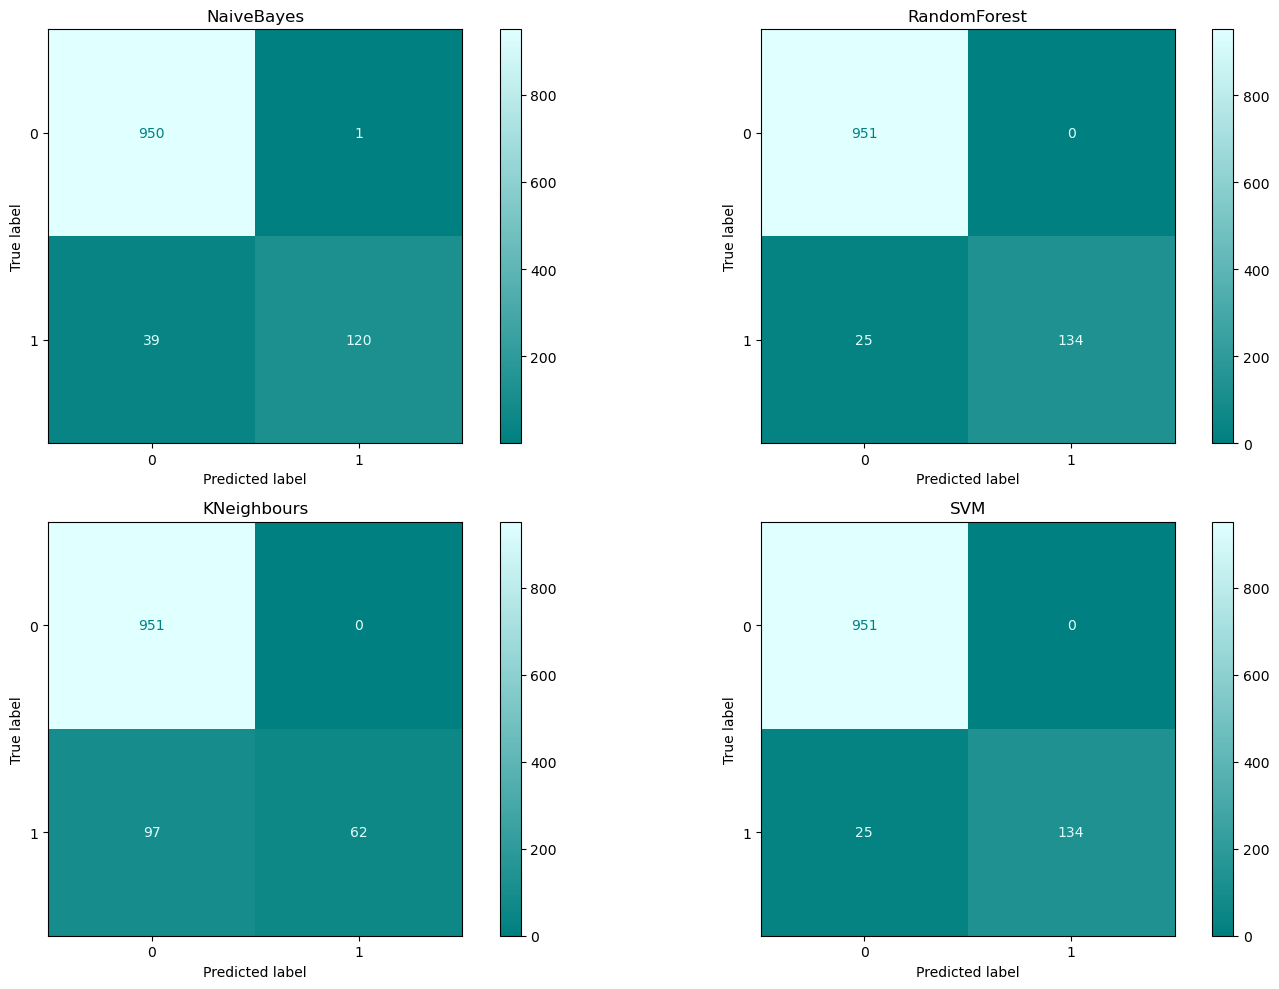

In [48]:
colors = [(0, 128/255, 128/255), (224/255, 255/255, 255/255)]  
custom_cmap = LinearSegmentedColormap.from_list('custom_teal', colors, N=256)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

for (name, clf), ax in zip(classifiers, axes.flatten()):
    disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax, cmap=custom_cmap)
    ax.title.set_text(name)

plt.tight_layout()
plt.show()

# Summary 

The model evaluation results demonstrate the performance of four different classifiers on the given dataset: Naive Bayes, Random Forest, K-Neighbors, and SVM (Support Vector Machine). The metrics used for comparison include Accuracy, Precision, Recall, F1-score, and ROC-AUC.

- Naive Bayes achieved an accuracy of 0.9650, precision of 0.9639, recall of 0.9619, F1-score of 0.9741, and ROC-AUC of 0.9639. This indicates a high overall performance, with particularly strong F1-score and ROC-AUC values.

- Random Forest performed exceptionally well with an accuracy of 0.9781, precision of 0.9775, recall of 0.9767, a perfect F1-score of 1.0000, and ROC-AUC of 0.9775. The perfect F1-score suggests that the Random Forest classifier perfectly balanced precision and recall in this context.

- K-Neighbors had a slightly lower performance compared to the other models, with an accuracy of 0.9207, precision of 0.9126, recall of 0.8956, F1-score of 0.9265, and ROC-AUC of 0.9126. Despite this, it still performed reasonably well, with an F1-score above 0.90.

- SVM matched the performance of the Random Forest classifier in terms of accuracy (0.9781), precision (0.9775), recall (0.9767), F1-score (0.9977), and ROC-AUC (0.9775). This indicates that SVM is also a highly effective model for this dataset.

Overall, the Random Forest and SVM classifiers demonstrated the best performance across all metrics, making them the top choices for this particular task. The Naive Bayes classifier also showed strong performance, while the K-Neighbors classifier, although slightly lower, still provided satisfactory results.

